In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [164]:
flight_number = 330
instrument = "ffssp"

def make_mphys_path(flight_number, instrument):
    return Path(f"20210614/{instrument}/nc_output/to{flight_number}_{instrument}_r1.nc")

def load_mphys_ds(flight_number, instrument):
    fn_src = make_mphys_path(flight_number=flight_number, instrument=instrument)

    return xr.open_dataset(fn_src)

ds = load_mphys_ds(flight_number=flight_number, instrument=instrument)

In [3]:
def _fix_flag_var(ds, var_name):
    
    flag_values = ds[var_name].flag_values
    if isinstance(flag_values, str):
        dtype = ds[var_name].dtype
        vals = [np.array(s.replace("b", ""), dtype=dtype) for s in ds[var_name].flag_values.split(",")]
        flag_values = np.array(vals)
    ds[var_name].attrs['flag_values'] = flag_values
    assert ds[var_name].attrs['flag_values'].dtype == ds[var_name].dtype
    
    ds[var_name].attrs['flag_meanings'] = format(" ".join(ds[var_name].flag_meanings.split()))
    
    return ds[var_name]

#_fix_flag_var(ds=ds, var_name="qc_flag_ambient_particle_number_per_channel")

In [4]:
def cffix(ds):
    # remove coordinates that don't have valid values anyway (they are all nans)

    for v in "longitude latitude".split():
        if v in ds:
            ds = ds.drop_dims(v)

    # drop variables we don't know the value for (also all nans)
    for v in "altitude platform_speed_wrt_air platform_pitch_angle platform_yaw_angle".split():
        if v in ds:
            ds = ds.drop(v)

    # ensure "coordinates" attributes is removed from encoding so
    # it isn't saved with stored file
    for v in ds.data_vars:
        if "coordinates" in ds[v].encoding:
            del(ds[v].encoding["coordinates"])

    # CF-conventions stipulates that "Conventions" attribute should be with capital C
    ds.attrs["Conventions"] = ds.attrs.pop("conventions")

In [6]:
from cfchecker.cfchecks import getargs, CFChecker, CFVersion
import warnings
import textwrap

class ValidationError(Exception):
    pass

class MyCFChecker(CFChecker):
    _logged_messages = []
    def _add_message(self, category, msg, var=None, code=None):
        self._logged_messages.append(locals())

def _check_file(filename, show_warnings=True):
    arglist = ["", filename]
    
    (badc, coards, debug, uploader, useFileName, regionnames, standardName, areaTypes, cacheDir, cacheTables, cacheTime,
     version, files) = getargs(arglist)
    
    # this will attempt auto-finding of version
    version = CFVersion()
                               
    inst = MyCFChecker(uploader=uploader,
                     useFileName=useFileName,
                     badc=badc,
                     coards=coards,
                     cfRegionNamesXML=regionnames,
                     cfStandardNamesXML=standardName,
                     cfAreaTypesXML=areaTypes,
                     cacheDir=cacheDir,
                     cacheTables=cacheTables,
                     cacheTime=cacheTime,
                     version=version,
                     debug=False,
                     silent=True)

    inst.checker(filename)
    
    file_errors = {}
    file_warnings = {}
    
    for lm in inst._logged_messages:
        category = lm["category"]
        msg = textwrap.indent(textwrap.fill(lm["msg"]), prefix="    ")
        var = lm["var"] if lm["var"] else "__global__"
        if category == "WARN":
            var_warnings = file_warnings.setdefault(var, [])
            var_warnings.append(msg)
        elif category == "ERROR":
            var_errors = file_errors.setdefault(var, [])
            var_errors.append(msg)
        elif category in ["VERSION", "INFO"]:
            pass
        else:
            raise NotImplementedError(category)
            
    if len(file_errors) > 0:
        print("The following errors were detected:")
        for var in sorted(file_errors.keys()):
            print(f"  {var}:")
            for error in file_errors[var]:
                print(f"{error}")
    else:
        print("no errors!")
                
                
    if show_warnings and len(file_warnings) > 0:
        print()
        print("The following warnings were raised:")
        for var in sorted(file_warnings.keys()):
            print(f"  {var}:")
            for warning in file_warnings[var]:
                print(f"{warning}")
    
_check_file(str(fn_cffixed))

The following errors were detected:
  latitude:
    co-ordinate variable not monotonic
  longitude:
    co-ordinate variable not monotonic
  qc_flag_ambient_particle_number_per_channel:
    Attribute flag_values of incorrect type (expecting 'Data Variable'
    type, got 'String' type)
    Invalid syntax for 'flag_meanings' attribute

The following warnings were raised:
  __global__:
    Cannot determine CF version from the Conventions attribute; checking
    against latest CF version: CF-1.8
    No 'Conventions' attribute present
    A variable with the attribute cf_role should be included in a Discrete
    Geometry CF File
    CF Files containing timeSeries featureType should only include a
    single occurrence of a cf_role attribute
  ambient_particle_number_per_channel:
    Coordinate variable time should have bounds or climatology attribute
  platform_pitch_angle:
    Coordinate variable time should have bounds or climatology attribute
  platform_speed_wrt_air:
    Coordinate vari

In [173]:
def load_cffixed_mphys_ds(flight_number, instrument):
    fn_src = make_mphys_path(flight_number=flight_number, instrument=instrument)
    fn_cffixed = Path("cf-fixed") / fn_src
    
    if not fn_cffixed.exists():
        ds = load_mphys_ds(flight_number=flight_number, instrument=instrument)
        ds = ds.copy()
        cffix(ds)
        fn_cffixed.parent.mkdir(exist_ok=True, parents=True)
        ds.to_netcdf(fn_cffixed)
        
        _check_file(str(fn_cffixed))

    return xr.open_dataset(fn_cffixed)

In [166]:
# fix timing error
ds = load_cffixed_mphys_ds(flight_number=flight_number, instrument=instrument)

In [130]:
def load_masin_ds(flight_number):
    fn_masin = f"/home/users/lcdenby/eurec4auk/public/data/obs/MASIN/EUREC4A_TO-{flight_number}_MASIN-1Hz_*_v0.6.nc"
    return xr.open_mfdataset(fn_masin).rename(dict(Time="time"))

ds_masin = load_masin_ds(flight_number=flight_number)

In [9]:
ds_masin.time.min().data, ds_masin.time.max().data

(array('2020-01-28T13:25:26.000000000', dtype='datetime64[ns]'),
 array('2020-01-28T17:13:53.000000000', dtype='datetime64[ns]'))

In [141]:
def extract_masin_window(ds_masin, dt_window, dt_fromtakeoff):
    ds_ = ds_masin.sel(time=slice(ds_masin.time.min() + dt_fromtakeoff, None))
    tn_w_max = ds_.W_OXTS.argmax(dim="time").compute().data
    t_w_max = ds_.isel(time=tn_w_max).time

    return ds_masin.sel(time=slice(t_w_max - dt_window, t_w_max + dt_window))

dt_window = np.timedelta64(5, "m")
dt_fromtakeoff = np.timedelta64(60, "m")
ds_masin_window = extract_masin_window(ds_masin=ds_masin, dt_window=dt_window, dt_fromtakeoff=dt_fromtakeoff)

In [11]:
ds_window = ds.sel(time=slice(ds_masin_window.time.min(), ds_masin_window.time.max()))

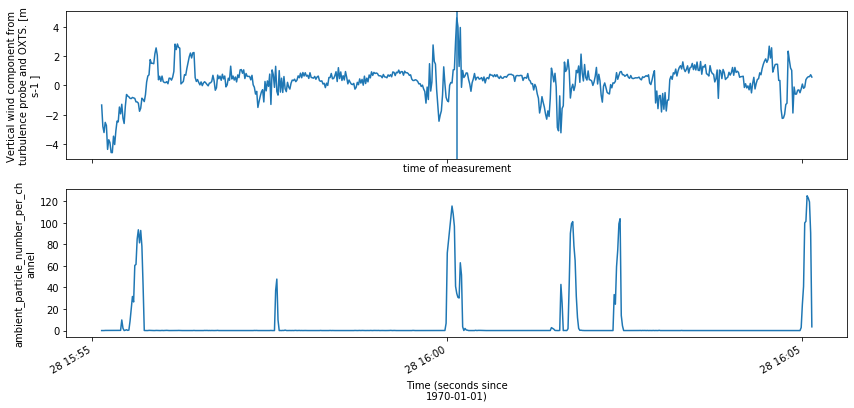

In [12]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 6), sharex=True)

ax = axes[0]
ds_masin_window.W_OXTS.plot(ax=ax)
ax.axvline(t_w_max.data)

ax = axes[1]
ds_window = ds.sel(time=slice(ds_masin_window.time.min(), ds_masin_window.time.max()))
ds_window.ambient_particle_number_per_channel.sum(dim="index").plot(ax=ax)

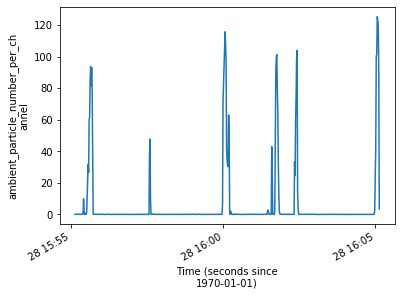

In [13]:
da_count = ds_window.interp_like(ds_masin_window).ambient_particle_number_per_channel.sum(dim="index")
da_count.plot()

((<Figure size 432x288 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f2c67a1b110>),
 268)

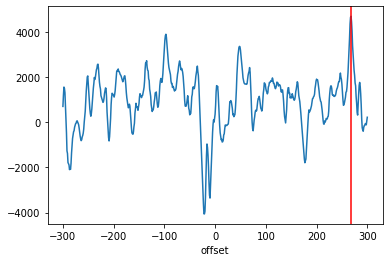

In [146]:
def calc_offset(da1, da2, show_plot=False):
    v1 = da1.fillna(0.0).values
    v2 = da2.fillna(0.0).values
    vv = np.fft.ifft(np.fft.fft(v1) * np.fft.fft(v2).conjugate()).real

    N = vv.shape[0]
    da_vv = xr.DataArray(
        np.roll(vv, N // 2), 
        dims=("offset"), coords=dict(offset=np.arange(N) - N // 2)
    )
    offset_max_corr = int(da_vv.isel(offset=da_vv.argmax(dim="offset")).offset.data)
    
    if show_plot:
        Ns = 1000
        fig, ax = plt.subplots()
        da_vv.sel(offset=slice(-Ns, Ns)).plot(ax=ax)
        ax.axvline(offset_max_corr, color="red")
        
        return (fig, ax), offset_max_corr
    else:
        return offset_max_corr
    
calc_offset(
    da1=ds_masin_window.W_OXTS,
    da2=da_count,
    show_plot=True
)

In [15]:
offset_max_corr

268

In [16]:
ds_offset = ds.roll(time=offset_max_corr, roll_coords=False)
ds_offset

<xarray.Dataset>
Dimensions:                                      (index: 30, latitude: 13687, longitude: 13687, time: 13687)
Coordinates:
  * time                                         (time) datetime64[ns] 2020-0...
  * latitude                                     (latitude) float32 nan ... nan
  * longitude                                    (longitude) float32 nan ... nan
Dimensions without coordinates: index
Data variables: (12/17)
    ambient_particle_diameter                    (index) float32 ...
    measurement_channel_lower_limit              (index) float32 ...
    measurement_channel_upper_limit              (index) float32 ...
    ambient_particle_number_per_channel          (time, index) float32 0.1717...
    number_of_instrument_counts_per_channel      (time, index) float32 486.0 ...
    qc_flag_ambient_particle_number_per_channel  (time, index) uint32 1 1 ... 1
    ...                                           ...
    year                                         (time) uint32 2020 ... 2020
    month                                        (time) uint32 1 1 1 1 ... 1 1 1
    day                                          (time) uint32 28 28 ... 28 28
    hour                                         (time) uint32 17 17 ... 17 17
    minute                                       (time) uint32 10 10 ... 10 10
    second                                       (time) float32 14.0 ... 13.0
Attributes: (12/42)
    conventions:                           CF-1.6, NCAS-AMF-2.0.0
    source:                                Manchester Cloud Droplet Probe
    instrument_manufacturer:               Droplet Measurement Technologies, USA
    instrument_model:                      CDP
    instrument_serial_number:              Not available
    instrument_software:                   pads.exe
    ...                                    ...
    location_keywords:                     Not applicable
    amf_vocabularies_release:              https://github.com/ncasuk/AMF_CVs/...
    history:                               2020-01-28T00:00:00Z - Data collec...
    comment:                               Data processing was performed to d...
    DataUse:                               Data is preliminary. Not for use w...
    measurement_technique:                 optical

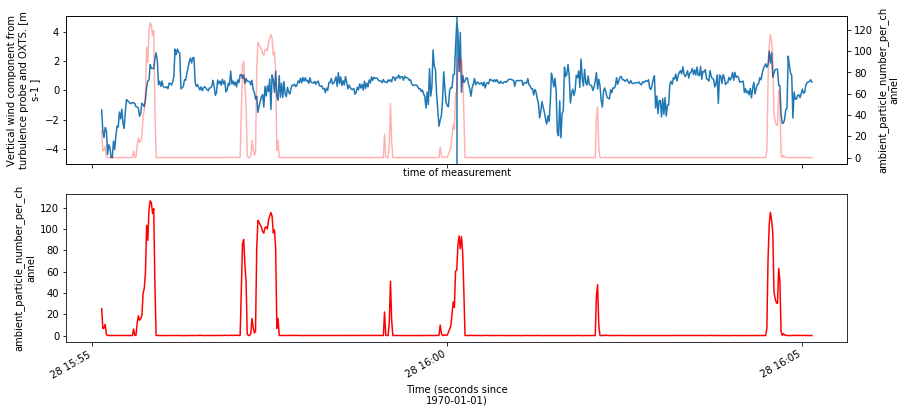

In [17]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 6), sharex=True)

ax = axes[0]
ds_masin_window.W_OXTS.plot(ax=ax)
ax.axvline(t_w_max.data)

ax = axes[1]
ds_offset_window = ds_offset.sel(time=slice(ds_masin_window.time.min(), ds_masin_window.time.max()))
ds_offset_window.ambient_particle_number_per_channel.sum(dim="index").plot(ax=ax, color="red")

ds_offset_window.ambient_particle_number_per_channel.sum(dim="index").plot(ax=axes[0].twinx(), alpha=0.3, color="red")

ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

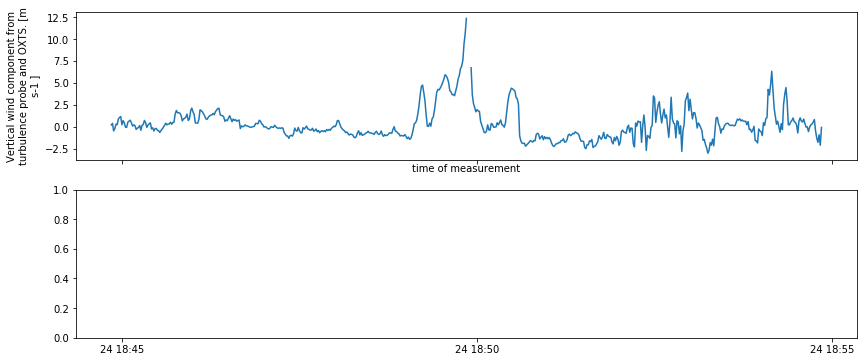

In [175]:
def _plot_comparison(da1, da2):
    fig, axes = plt.subplots(nrows=2, figsize=(14, 6), sharex=True)

    ax = axes[0]
    da1.plot(ax=ax)

    ax = axes[1]
    da2_window = da2.sel(time=slice(da1.time.min(), da1.time.max()))
    da2_window.plot(ax=ax, color="red")

    da2_window.plot(ax=axes[0].twinx(), alpha=0.3, color="red")
    
    return fig, axes
    
fig, axes = _plot_comparison(
    da1=ds_masin_window.W_OXTS,
    da2=ds.ambient_particle_number_per_channel.sum(dim="index")
)
fig.suptitle("original data")

268


Text(0.5, 0.98, 'offset by 268seconds')

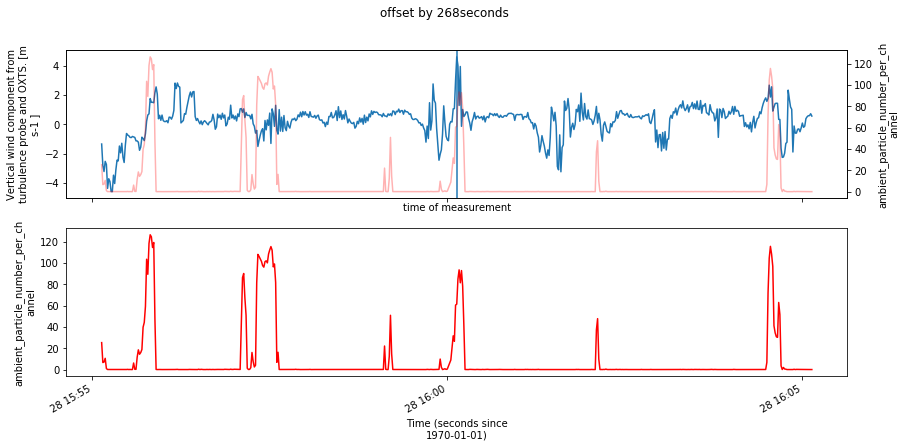

In [19]:
print(offset_max_corr)
fig, axes = _plot_comparison(
    da1=ds_masin_window.W_OXTS,
    da2=ds_offset.ambient_particle_number_per_channel.sum(dim="index")
)
fig.suptitle("offset by {}seconds".format(offset_max_corr))

In [127]:
import yaml
!rm {fn_offsets}

In [126]:
fn_offsets = Path("offsets.yaml")

def getset_offset(flight_number, instrument, new_value=None):
    if not fn_offsets.exists():
        if new_value:
            data = { flight_number: { instrument: new_value }}
        else:
            data = { flight_number: {} }
    else:
        with open(fn_offsets) as fh:
            data = yaml.load(fh, Loader=yaml.FullLoader) 
        if new_value:
            data.setdefault(flight_number, {}).setdefault(instrument, new_value)
    
    with open(fn_offsets, "w") as fh:
        yaml.dump(data, fh)
        
    print(data)
        
    return data[flight_number].get(instrument)

def offsets_to_df():
    with open(fn_offsets) as fh:
        data = yaml.load(fh, Loader=yaml.FullLoader)
        
    df = pd.DataFrame(data.values(), index=data.keys())
    df.index.name = "flight_number"
    return df
    
getset_offset(flight_number=332, instrument="fssp", new_value=12)
offsets_to_df()

{332: {'fssp': 12}}


,fssp
flight_number,
332,12


In [128]:
# processing all files

{330: {'ffssp': 237}}


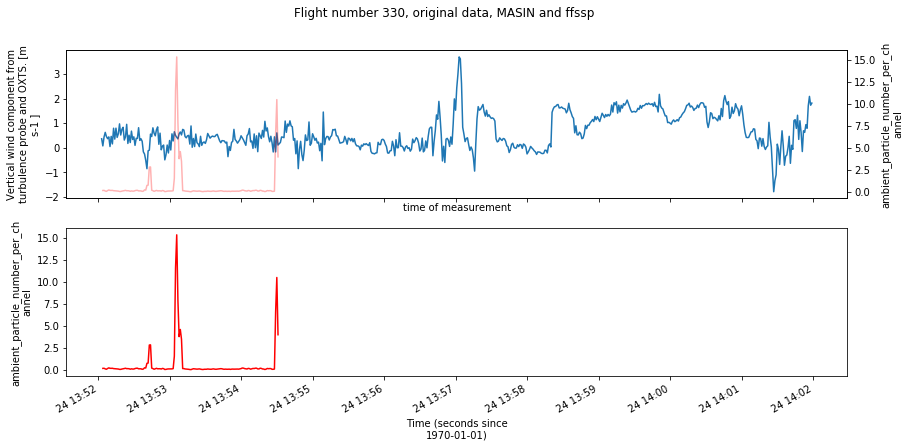

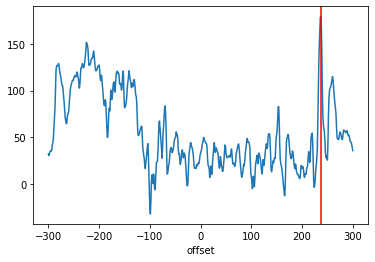

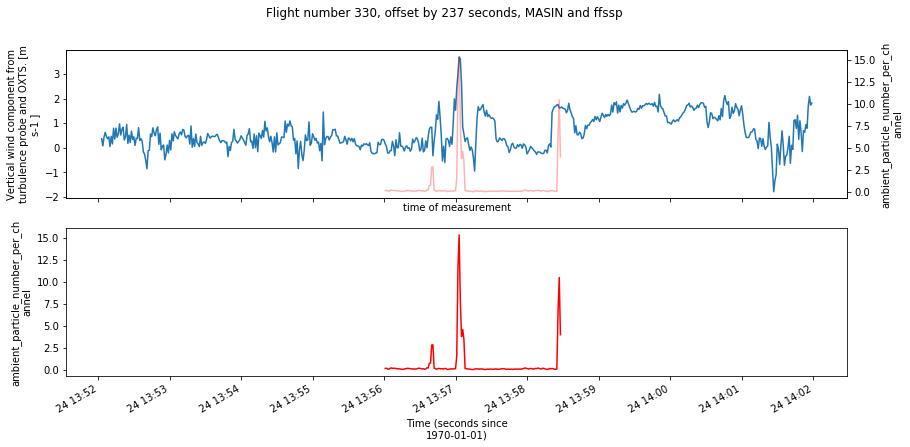

In [180]:
masin_var = "W_OXTS"
dt_window = np.timedelta64(5, "m")
dt_fromtakeoff = np.timedelta64(60, "m")


for flight_number in [330,]:
    for instrument in ["cdp", "ffssp"]:
        try:
            ds_mphys = load_cffixed_mphys_ds(flight_number=flight_number, instrument=instrument)
        except FileNotFoundError:
            continue
        ds_masin = load_masin_ds(flight_number=flight_number)

        ds_masin_window = extract_masin_window(ds_masin=ds_masin, dt_window=dt_window, dt_fromtakeoff=dt_fromtakeoff)
        ds_mphys_window = ds_mphys.sel(time=slice(ds_masin_window.time.min(), ds_masin_window.time.max()))

        da_masin_window = ds_masin_window[masin_var]
        da_mphys_window = ds_mphys_window.ambient_particle_number_per_channel.sum(dim="index").interp_like(ds_masin_window)

        fn_comparison_original = f"TO{flight_number}.MASIN_vs_{instrument}.original.png"
        fn_correlation = f"TO{flight_number}.MASIN_vs_{instrument}.{masin_var}_npart_correll.png"
        fn_comparison_offset = f"TO{flight_number}.MASIN_vs_{instrument}.offset.png"
        
        fig, axes = _plot_comparison(da1=da_masin_window, da2=da_mphys_window)
        fig.suptitle(f"Flight number {flight_number}, original data, MASIN and {instrument}")
        fig.savefig(fn_comparison_original)
        
        (fig, ax), offset = calc_offset(
            da1=da_masin_window,
            da2=da_mphys_window,
            show_plot=True
        )
        fig.savefig(fn_correlation)

        da_mphys_window_offset = da_mphys_window.roll(time=offset, roll_coords=False)
        fig, axes = _plot_comparison(da1=da_masin_window, da2=da_mphys_window_offset)
        fig.suptitle(f"Flight number {flight_number}, offset by {offset} seconds, MASIN and {instrument}")
        fig.savefig(fn_comparison_offset)
        
        getset_offset(flight_number=flight_number, instrument=instrument, new_value=offset)
        break

In [179]:
offsets_to_df()

,ffssp
flight_number,
330,237


In [181]:
import datetime

In [185]:
ds

<xarray.Dataset>
Dimensions:                                      (index: 21, time: 9841)
Coordinates:
  * time                                         (time) datetime64[ns] 2020-0...
Dimensions without coordinates: index
Data variables: (12/13)
    ambient_particle_diameter                    (index) float32 ...
    measurement_channel_lower_limit              (index) float32 ...
    measurement_channel_upper_limit              (index) float32 ...
    ambient_particle_number_per_channel          (time, index) float32 0.0 .....
    number_of_instrument_counts_per_channel      (time, index) float32 ...
    qc_flag_ambient_particle_number_per_channel  (time, index) uint32 ...
    ...                                           ...
    year                                         (time) uint32 ...
    month                                        (time) uint32 ...
    day                                          (time) uint32 ...
    hour                                         (time) uint32 ...
    minute                                       (time) uint32 ...
    second                                       (time) float32 ...
Attributes: (12/42)
    source:                                Manchester Fast Forward Scattering...
    instrument_manufacturer:               Spec inc., USA
    instrument_model:                      FFSSP
    instrument_serial_number:              Not available
    instrument_software:                   pads.exe
    instrument_software_version:           Not available
    ...                                    ...
    amf_vocabularies_release:              https://github.com/ncasuk/AMF_CVs/...
    history:                               2020-01-24T00:00:00Z - Data collec...
    comment:                               Data processing was performed to d...
    DataUse:                               Data is preliminary. Not for use w...
    measurement_technique:                 optical
    Conventions:                           CF-1.6, NCAS-AMF-2.0.0